[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/master/scripts/interactive/example_inferring_Rt.ipynb)

In [ ]:
!pip install covid19_inference



# Example inferring the time dependent reproduction number R_t

This example shows how to infer the time dependent reproduction number R_t from the number of new cases.

Runtime ~ 1.5h

As always first some imports


In [1]:
import datetime
import sys
import numpy as np
import pickle
import aesara
import aesara.tensor as at
import matplotlib.pyplot as plt
import pymc as pm

In [2]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19


## Data retrieval

The next thing we want to do is (down)load a dataset. We have retrievers for multiple download sources.
Documentation can be found [here](https://covid19-inference.readthedocs.io/en/latest/doc/data_retrieval.html).
In this example we will use the JHU dataset.


In [3]:
jhu = cov19.data_retrieval.JHU()
jhu.download_all_available_data()

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local




We select the data range and country we want to analyze.


In [4]:
bd = datetime.datetime(2021, 3, 10)  # For the date filter
ed = datetime.datetime(2021, 5, 10)
new_cases_obs = jhu.get_new(
    value="confirmed", country="Germany", data_begin=bd, data_end=ed
)



## Create the model

First we need to set the priors for the change points and other configs.


In [5]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 10

In [6]:
# We set the priors for the changepoints here
# We set a possible change point every 10 days
from covid19_inference.model.spreading_rate.change_points import get_cps

In [7]:
change_points = get_cps(
    data_begin=bd - datetime.timedelta(days=10),
    data_end=ed,
    offset=5,
    interval=10,
    **dict(
        relative_to_previous=True,
        pr_factor_to_previous=1.0,
        pr_sigma_transient_len=1,
        pr_median_transient_len=4,
        pr_sigma_date_transient=2.5,
    ),
)
pr_delay = 7

INFO     [covid19_inference.model.utility] pr_sigma_lambda was set to default value 0.2
INFO     [covid19_inference.model.utility] pr_median_lambda was set to default value 0.125


In [8]:
params_model = dict(
    new_cases_obs=new_cases_obs,
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=84e6,
)

In [9]:
with cov19.model.Cov19Model(**params_model) as this_model:

    # We construct a typical slowly changing base reproduction number
    # using sigmoidals. Even though the function is called lambda_t
    # the specific values are controlled by the priors and are around one.
    # https://science.sciencemag.org/content/369/6500/eabb9789.full
    sigma_lambda_cp = pm.HalfCauchy(
        name="sigma_lambda_cp",
        beta=1,
        transform=pm.distributions.transforms.log_exp_m1,
    )
    sigma_lambda_week_cp = None
    R_t_log = cov19.model.lambda_t_with_sigmoids(
        change_points_list=change_points,
        pr_median_lambda_0=1,
        pr_sigma_lambda_0=0.3,
        sigma_lambda_cp=sigma_lambda_cp,
        sigma_lambda_week_cp=sigma_lambda_week_cp,
    )
    R_t = pm.Deterministic("R_t", at.exp(R_t_log))

    # This builds a decorrelated prior for E_begin for faster inference. It is not
    # necessary to use it, one can simply remove it and use the default argument for
    # pr_E_begin in cov19.kernelized_spread gender
    new_E_begin = cov19.model.uncorrelated_prior_E()

    # Compartmental model using kernelized spread
    I = cov19.model.kernelized_spread(R_t=R_t, new_E_begin=new_E_begin)

    # Delay the cases by a gamma reporting delay
    new_cases = cov19.model.delay_cases(
        cases=I,
        delay_kernel="gamma",
        median_delay_kwargs={
            "mu": pr_delay,
            "sigma": 0.1,
        },
        scale_delay_kwargs={
            "mu": 1 / 5 * pr_delay,
            "sigma": 0.4 / 5 * pr_delay,
        },
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(new_cases,week_modulation_type="by_weekday")
    pm.Deterministic("new_cases", new_cases)

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate.lambda_t_with_sigmoids] Lambda_t with sigmoids
INFO     [covid19_inference.model.compartmental_models.uncorrelated_priors] Compartmental Model (Uncorrelated prior E)
INFO     [covid19_inference.model.compartmental_models.kernelized_spread] Compartmental Model (Kenerlized Spread)
INFO     [covid19_inference.model.delay] Delaying cases
INFO     [covid19_inference.model.week_modulation] Week modulation (by weekday)
INFO     [covid19_inference.model.likelihood] StudentT likelihood



## MCMC sampling

After the model is built, it is sampled using a MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
The sampling can take a long time.


In [10]:
# Sampling using the experimenal jax sampler
# Not working (yet) will keep this here just in case
# from pymc.sampling_jax import sample_numpyro_nuts
# idata = sample_numpyro_nuts(
#     model=this_model,
#     tune=1000,
#     draws=1000
# )

In [ ]:
idata = pm.sample(model=this_model, tune=1000, draws=1000)

Auto-assigning NUTS sampler...
INFO     [pymc] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc] Initializing NUTS using jitter+adapt_diag...


### Optional Save & Load the trace

You can run the box below to save the trace or load it.

In [ ]:
with open("./germany_inferring_Rt_idata.pkl", "wb") as f:
        pickle.dump(idata, f)

In [11]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
idata = load("./germany_inferring_Rt_idata.pkl")


 ## Plotting

As our goal is to infer the reproduction number, we plot the posterior of the reproduction number
here.


In [15]:
from covid19_inference.plot import _timeseries, get_array_from_idata_via_date

In [19]:
# Get R_t and cases trace with util function
R_t, dates_RT = get_array_from_idata_via_date(this_model, idata, "R_t")
cases, dates_cases = get_array_from_idata_via_date(this_model, idata, "new_cases")

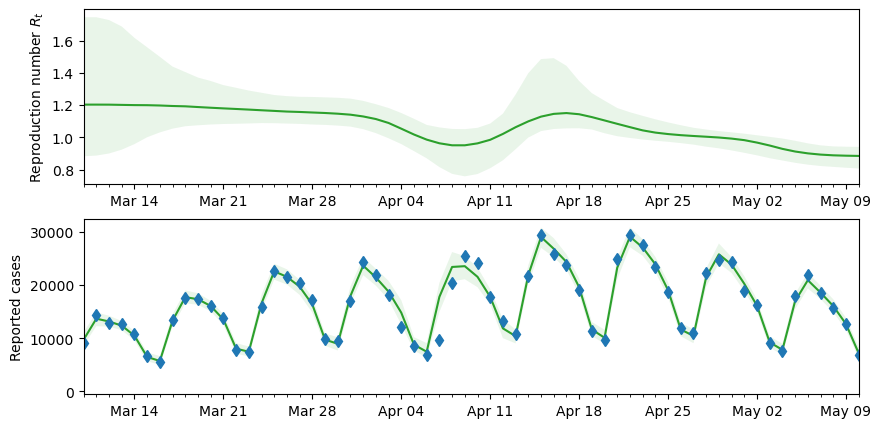

In [21]:
# Create figure
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
# Plot Rt
_timeseries(
    x=dates_RT,
    y=R_t,
    ax=axes[0],
    what="model"
)
# Plot cases (model)
_timeseries(
    x=dates_cases,
    y=cases,
    ax=axes[1],
    what="model"
)
# Plot cases (data)
_timeseries(
    x=new_cases_obs.index,
    y=new_cases_obs,
    ax=axes[1]
)
# Markup
for ax in axes:
    ax.set_xlim(this_model.data_begin,this_model.data_end)

# 
axes[0].set_ylabel("Reproduction number $R_t$")
axes[1].set_ylabel("Reported cases") 
plt.show()

In [22]:
%load_ext watermark
%watermark -iv

aesara           : 2.8.7
numpy            : 1.23.5
sys              : 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:26:04) [GCC 10.4.0]
covid19_inference: 0.5.0
matplotlib       : 3.6.2
pymc             : 4.4.0

